In [3]:
import numpy as np
import pandas as pd
from scraper import StockInfo
import json
import matplotlib.pyplot as plt
import math

In [64]:
ticker = "TMUS"
tick = StockInfo(ticker)
df = pd.read_csv('csv/tickers.csv')
f = open('valJSON.json')
data = json.loads(json.loads(f.read()))

data = data[ticker]
price = tick.get_marketStockPrice()

[*********************100%***********************]  1 of 1 completed


In [65]:
def remap( x, oMin, oMax, nMin, nMax ):
    reverseInput = False
    oldMin = min( oMin, oMax )
    oldMax = max( oMin, oMax )
    if not oldMin == oMin:
        reverseInput = True

    reverseOutput = False   
    newMin = min( nMin, nMax )
    newMax = max( nMin, nMax )
    if not newMin == nMin :
        reverseOutput = True

    portion = (x-oldMin)*(newMax-newMin)/(oldMax-oldMin)
    if reverseInput:
        portion = (oldMax-x)*(newMax-newMin)/(oldMax-oldMin)

    result = portion + newMin
    if reverseOutput:
        result = newMax - portion

    return result

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def centerData(mean, data):
    data = data - mean
    return data

In [66]:
prob = data["y"] / np.sum(data["y"])
x = data["x"]


mux, sd = weighted_avg_and_std(data["x"], prob)
print(mux, sd)
x = np.array([-1 + 2 * (z - min(x)) / (max(x) - min(x)) for z in x])
meanx, stdx = weighted_avg_and_std(x, prob)
x = x - meanx

meanx

113.06898880698141 42.55461726873115


-0.6221935483870966

In [67]:
remap(x + meanx, -1, 1, np.min(data["x"]), np.max(data["x"]))

array([ 40.86372954,  53.19386261,  65.52399569,  77.85412876,
        90.18426183, 102.5143949 , 114.84452797, 127.17466104,
       139.50479411, 151.83492718, 164.16506025, 176.49519332,
       188.82532639, 201.15545947, 213.48559254, 225.81572561,
       238.14585868, 250.47599175, 262.80612482, 275.13625789,
       287.46639096, 299.79652403, 312.1266571 , 324.45679017,
       336.78692325, 349.11705632, 361.44718939, 373.77732246,
       386.10745553, 398.4375886 , 410.76772167, 423.09785474])

(array([0.241, 0.419, 0.223, 0.076, 0.026, 0.006, 0.004, 0.003, 0.001,
        0.001]),
 array([-0.37780645, -0.17780645,  0.02219355,  0.22219355,  0.42219355,
         0.62219355,  0.82219355,  1.02219355,  1.22219355,  1.42219355,
         1.62219355]),
 <BarContainer object of 10 artists>)

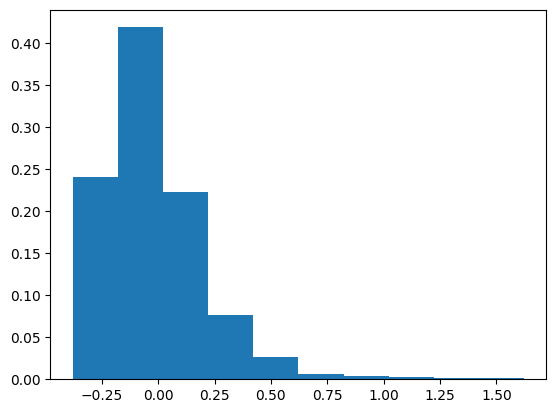

In [68]:
plt.hist(x=x, weights=prob)

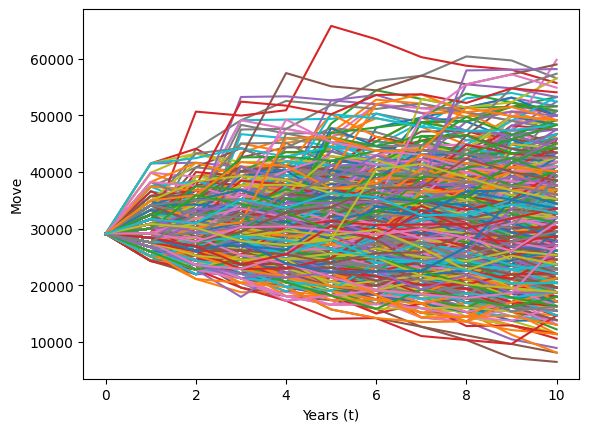

In [69]:
M = 1000 # number of simulations
t = 10 # Time
n = 10

steps = (1/np.sqrt(n)) * np.random.choice(x, p=prob, size=(M, n)).T
origin = np.zeros((1,M))
srw_paths = np.concatenate([origin, steps]).cumsum(axis=0)

time = np.linspace(0,t,n+1)
tt = np.full(shape=(M, n+1), fill_value=time)
tt = tt.T


#srw_paths = remap(srw_paths + meanx, -1, 1, np.min(data["x"]), np.max(data["x"]))
#srw_paths = (srw_paths + meanx) * price
srw_paths = remap(srw_paths, np.min(srw_paths), np.max(srw_paths), np.min(data["x"]), np.max(data["x"])) * price + price
plt.plot(tt,srw_paths)
plt.xlabel("Years (t)")
plt.ylabel("Move")
plt.show()

In [70]:
np.mean(srw_paths[5])

29440.134347385458

In [71]:
np.random.choice(x, p=prob, size=(10, 2)).T

array([[ 0.33187097, -0.18425806,  0.13832258,  0.00929032,  0.20283871,
         0.00929032,  0.13832258, -0.05522581,  0.00929032,  0.07380645],
       [-0.18425806, -0.18425806, -0.11974194,  0.07380645,  0.00929032,
        -0.18425806, -0.18425806, -0.05522581,  0.00929032,  0.33187097]])

In [72]:
M = 1000 # number of simulations
t = 10 # Time
n = 100 # steps we want to see
dt = t/n # time step

In [73]:
steps = np.random.choice(x, p=prob, size=(M, n)).T
origin = np.zeros((1,M))
bm_paths = np.concatenate([origin, steps]).cumsum(axis=0)
bm_paths = remap(bm_paths + meanx, -1, 1, np.min(data["x"]), np.max(data["x"]))

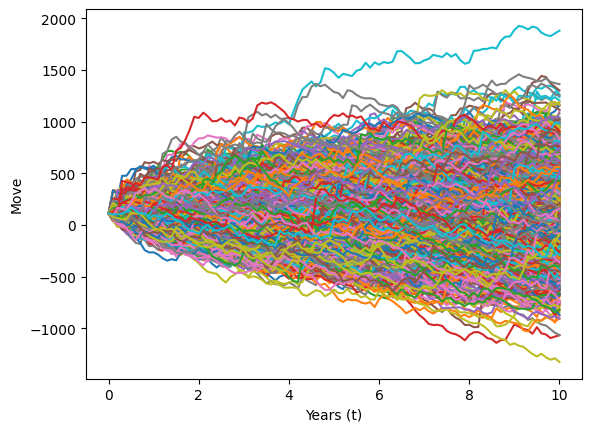

In [74]:
time = np.linspace(0,t,n+1)
tt = np.full(shape=(M, n+1), fill_value=time)
tt = tt.T

plt.plot(tt,bm_paths)
plt.xlabel("Years (t)")
plt.ylabel("Move")
plt.show()

In [75]:
# drift coefficent
mu = 0.001
# number of steps
n = 100
# time in years
T = 10
# number of sims
M = 1000
# initial stock price
S0 = price
# volatility
sigma = np.std(x)
# calc each time step
dt = T/n

# simulation using numpy arrays
St = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.choice(x, p=prob, size=(M, n)).T
)

# include array of 1's
St = np.vstack([np.ones(M), St])

# multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0).
St = S0 * St.cumprod(axis=0)

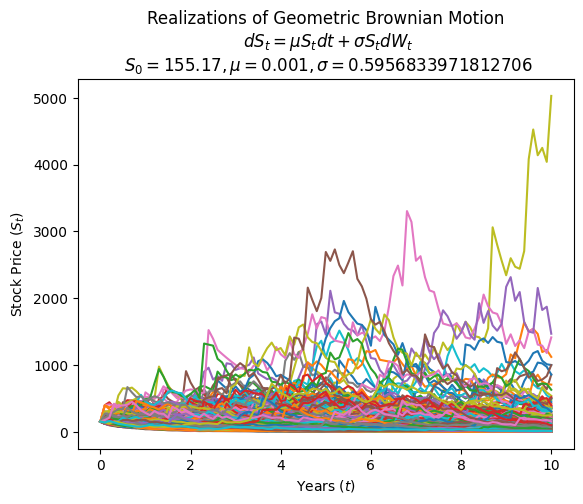

In [76]:
# Define time interval correctly
time = np.linspace(0,T,n+1)
# Require numpy array that is the same shape as St
tt = np.full(shape=(M,n+1), fill_value=time).T

plt.plot(tt, St)
plt.xlabel("Years $(t)$")

plt.ylabel("Stock Price $(S_t)$")
plt.title(
    "Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(S0, mu, sigma)
)
plt.show()

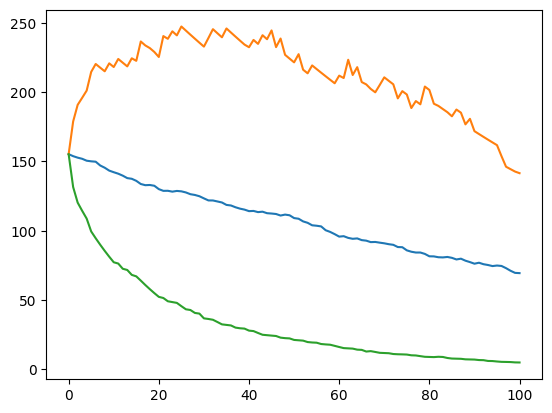

In [77]:
gbm90 = []
gbm10 = []

meanGBM = []
for i in range(len(St)):
    gbm90.append(np.percentile(St[i], 90))
    gbm10.append(np.percentile(St[i], 10))
    meanGBM.append(np.mean(St[i]))
    
plt.plot(meanGBM)
plt.plot(gbm90)
plt.plot(gbm10)